In [0]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 2s (213 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 134448 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 784 kB of 

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [0]:
import gym
env = gym.make("CartPole-v0")
import collections
import torch
import torch.nn as n
import torch.optim as op
import torch.nn.functional as f
import cv2

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
class fireresetwrapper(gym.Wrapper):
  def __init__(self,env):
    super().__init__(env)
    self.env=env

  def step(self,action):
    return self.env.step(action)
  
  def reset(self):
    print("a")
    self.env.reset()
    obs,_,isdone,_=self.env.step(1)

    if isdone:
      self.env.reset()
    
    obs,_,isdone,_=self.env.step(2)

    if isdone:
      self.env.reset()
    return obs

In [0]:
class maxandskipenv(gym.Wrapper):
  def __init__(self,env,skip=4):
    super().__init__(env)
    self.env=env
    self.skip=skip
    self.buffer=collections.deque(maxlen=2)
  

  def step(self,action):
    totalreward=0
    done=None

    for _ in range(self.skip):
      obs,rew,isdone,info=self.env.step(action)
      totalreward+=rew
      self.buffer.append(obs)
      if isdone:
        break

    obs=np.max(np.stack(self.buffer),axis=0)
    return obs,totalreward,isdone,info
    
  def reset(self):
    print("b")
    self.buffer.clear()
    obs=self.env.reset()
    self.buffer.append(obs)
    return obs


In [0]:
class processimage84(gym.ObservationWrapper):
  def __init__(self,env):
    super().__init__(env)
    self.env=env
    
  def observation(self,x):
    print("1")
    return processimage84.process(x)

  @staticmethod
  def process(ob):
    img=np.reshape(ob,[210,160,3]).astype(np.float32)
    img=img[:,:,0]*0.299+img[:,:,1]*0.587+img[:,:,2]*0.114
    resizedimg=cv2.resize(img,(84,110),interpolation=cv2.INTER_AREA)
    xt=resizedimg[18:102,:]
    xt=np.reshape(xt,(84,84,1))
    return xt.astype(np.uint8)

In [0]:
class bufferwrapper(gym.ObservationWrapper):
  def __init__(self,env,nstep,dtype=np.float32):
    super().__init__(env)
    self.dtype=dtype
    oldspace=env.observation_space
    self.observation_space=gym.spaces.Box(low=0,high=255,shape=[nstep,84,84],dtype=dtype)
    self.env=env

  def reset(self):
    print("c")
    #arr1=np.stack(np.array_split(self.observation_space.low,4,axis=0),axis=0)
    self.buffer=np.zeros_like(self.observation_space.low,dtype=self.dtype)
    return self.observation(self.env.reset())  # within self.env.reset() previous wrapper with reset is called
  
  def observation(self,obs):
    print("2")
    print(obs.shape)

    self.buffer[:-1]=self.buffer[1:]
    self.buffer[:-1]=obs
    print(self.buffer.shape)
    return self.buffer


In [0]:
# change HWC to CHW
class imagetopytorch(gym.ObservationWrapper):
  def __init__(self,env):
    super().__init__(env)
    self.env=env
    oldshape=self.observation_space.shape
    self.observation_space=gym.spaces.Box(0,1,shape=(oldshape[-1],oldshape[0],oldshape[1]),dtype=np.float32)

  def observation(self,x):
    print("3")
    return np.moveaxis(x,2,0)

In [0]:
class scaledfloatframe(gym.ObservationWrapper):
  def  __init__(self,env):
    super().__init__(env)
    self.env=env
    
  def observation(self,obs):
    print("4")
    return np.array(obs).astype(np.float32)/255.0

In [0]:
env1=gym.make("PongNoFrameskip-v4")

In [0]:
env1=maxandskipenv(env1)       # obs    #reset   #  b
env1=fireresetwrapper(env1)                      #  a
env1=processimage84(env1)      # 1               
env1=imagetopytorch(env1)      # 3
env1=bufferwrapper(env1,4)     # 2               #  c
env1=scaledfloatframe(env1)    # 4

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
env1.reset()

c
a
b
1
3
2
(1, 84, 84)
(4, 84, 84)
4


array([[[0.34117648, 0.34117648, 0.34117648, ..., 0.34117648,
         0.34117648, 0.34117648],
        [0.34117648, 0.34117648, 0.34117648, ..., 0.34117648,
         0.34117648, 0.34117648],
        [0.34117648, 0.34117648, 0.34117648, ..., 0.34117648,
         0.34117648, 0.34117648],
        ...,
        [0.34117648, 0.34117648, 0.34117648, ..., 0.34117648,
         0.34117648, 0.34117648],
        [0.34117648, 0.34117648, 0.34117648, ..., 0.34117648,
         0.34117648, 0.34117648],
        [0.56078434, 0.56078434, 0.56078434, ..., 0.56078434,
         0.56078434, 0.56078434]],

       [[0.34117648, 0.34117648, 0.34117648, ..., 0.34117648,
         0.34117648, 0.34117648],
        [0.34117648, 0.34117648, 0.34117648, ..., 0.34117648,
         0.34117648, 0.34117648],
        [0.34117648, 0.34117648, 0.34117648, ..., 0.34117648,
         0.34117648, 0.34117648],
        ...,
        [0.34117648, 0.34117648, 0.34117648, ..., 0.34117648,
         0.34117648, 0.34117648],
        [0.3

In [0]:
a=env1.step(3)

1
3
2
(1, 84, 84)
(4, 84, 84)
4


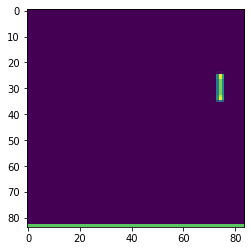

In [0]:
plt.imshow(a[0][0].squeeze())

In [0]:
# from self.env.reset() in last wrapper with reset in it . previous wrapper is called with reset() function inside it and so on
# for observation when last wrapper is called then observation is called from the first wrapper in order

3
t
i
(1, 84, 84)


ValueError: ignored

In [0]:
a[0].shape

(210, 160, 3)

In [0]:
# fire >max skip > observation >

In [0]:
# within the wrapper reset act first then observation function

In [0]:
arr1=np.random.randint(0,16,(6,3,3))

In [0]:
l=np.array_split(arr1,3,axis=0)

In [0]:
np.stack(l,axis=0).shape

(3, 2, 3, 3)

In [0]:
arr1[:2]

array([[[10,  5,  8],
        [14,  2, 11],
        [ 5, 10, 14]],

       [[11, 12, 15],
        [ 6, 10,  9],
        [12,  9,  9]]])